# Home Presence Prediction

This kernel is a personal training project. It aim's to predict the temperature in my appartment at a specific time to have the right temperature when I will be back home

In [1]:
import pandas as pd
import numpy as np
import time
import datetime
from datetime import date
import tqdm
import matplotlib
import matplotlib.pyplot as plt
import pickle

%matplotlib inline
matplotlib.style.use('ggplot')

# Retrieve Data

In [2]:
data = pd.read_csv('./export_presence.csv') # File not in the git repo 
data = data[ data['id'] % 2 ==0]
data = data.reset_index(drop=True)
print(data.columns)

Index(['id', 'date', 'presence'], dtype='object')


# Preprocessing Data

In [3]:
data = data.assign(hour = [ str() for i in range(data.shape[0]) ])
data = data.assign(weekday = [ np.nan for i in range(data.shape[0]) ])
data.columns

j=0
for value in data.values:
    data.at[j, 'hour'] = value[3] = value[1].split(' ')[1].split('.')[0][:5]
    data.at[j, 'date'] = value[1] = value[1].split(' ')[0]
        
    split_date = value[1].split('-')
    data.at[j, 'weekday'] = date(int(split_date[0]), int(split_date[1]), int(split_date[2])).weekday()
    
    j+=1

data['hour'] = data['hour'].apply(lambda x: int(x.split(':')[0])*3600+int(x.split(':')[1])*60)
data['date'] = data['date'].apply(lambda x: time.mktime(datetime.datetime.strptime(x, "%Y-%m-%d").timetuple()) - time.mktime(datetime.datetime.strptime(x.split('-')[0], "%Y").timetuple()))

data.head(10)

,id,date,presence,hour,weekday
0,16,1814400.0,0,27600,0.0
1,18,1814400.0,0,27840,0.0
2,20,1814400.0,0,28080,0.0
3,22,1814400.0,0,28320,0.0
4,24,1814400.0,0,28560,0.0
5,26,1814400.0,0,28800,0.0
6,28,1814400.0,0,29040,0.0
7,30,1814400.0,0,29280,0.0
8,32,1814400.0,0,29520,0.0
9,34,1814400.0,0,29760,0.0


In [4]:
from sklearn.preprocessing import MinMaxScaler

X = data[data.columns.drop('presence')]
scaler_x = MinMaxScaler()
X_scale = scaler_x.fit_transform(X)

y = data['presence']

/home/sebastien/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


# Data visualisation

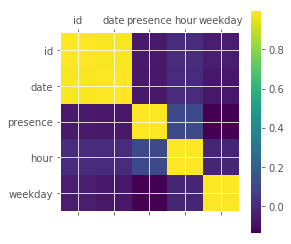

In [5]:
data_corelation = data.copy()
corr_matrix = data_corelation.corr()
plt.matshow(corr_matrix)
plt.xticks(range(len(corr_matrix.index)), corr_matrix.index)
plt.yticks(range(len(corr_matrix.index)), corr_matrix.index)
plt.colorbar()
plt.show()

In [8]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# Create training dataset
train_X, test_X, train_y, test_y = train_test_split(X_scale, y, random_state = 1)

from xgboost import XGBClassifier
from sklearn.metrics import mean_absolute_error

xgb_model = XGBClassifier(base_score=0.2, booster='gbtree', learning_rate=0.39, max_depth = 7)
xgb_model.fit(train_X, train_y, verbose=False)
val_pred = xgb_model.predict(test_X)
xgb_score = xgb_model.score(test_X, test_y)

pickle.dump(xgb_model, open('./presence.model.pickle', "wb"))

print(mean_squared_error(val_pred, test_y))
print(xgb_score)

0.06240571655418817
0.9375942834458119


In [9]:
loaded_model = pickle.load(open("./presence.model.pickle", "rb"))
# make predictions for test data
y_pred = loaded_model.predict(test_X)
# evaluate predictions
print(loaded_model.score(test_X, test_y))

0.9375942834458119
